# Jogo da Forca com Jogador Automático Utilizando Teoria da Informação

Neste projeto, vamos implementar um jogador automático de forca que utiliza conceitos de teoria da informação, como frequência de letras e entropia, para adivinhar a palavra secreta com o mínimo de tentativas possível. O jogador possui apenas 5 vidas para adivinhar as palavras e tenta maximizar suas chances filtrando o vocabulário a cada tentativa.


In [1]:
# Importação das bibliotecas necessárias
import requests
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


### Explicação
Esta célula importa as bibliotecas essenciais para o funcionamento do jogo. Utilizamos `requests` para carregar o vocabulário, `collections` para contagem de letras, `numpy` e `pandas` para manipulação de dados.

### Jogador
A classe `Jogador` representa o jogador automático e inclui métodos para:
- Inicializar o vocabulário baseado no comprimento da palavra.
- Contar as ocorrências de cada letra no vocabulário.
- Filtrar palavras de acordo com as tentativas e posições corretas.
- Selecionar a letra com a maior frequência restante para tentar adivinhar.

In [2]:
import requests, collections
import scipy.stats as stats
import numpy as np
import pandas as pd

class Jogador:
    def __init__(self, len_palavra):

        self.len_palavra = len_palavra
        self.palavra = np.empty(len_palavra, dtype=str) # Inicializa array da palavra

        self.vocabulario = self.init_vocab() # Matriz de palavras disponíveis
        self.probs  = self.compute_probs() # Inicializa probabilidades de cada letra

    def init_vocab(self):
        """
        Faz request de palavras disponíveis, e transforma em matriz.

        Returns:
            numpy.ndarray : Matriz com palavras x linhas
        """
        r = requests.get('https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt', allow_redirects=True)

        if r.status_code == 200:
            palavras = str(r.content.decode()).split('\n')
        else:
            return None
        
        return pd.DataFrame([list(palavra) for palavra in palavras if len(palavra) == self.len_palavra]).to_numpy()
        
    def compute_probs(self):
        """
        Conta ocorrências de cada letra disponível no vocabulário.

        Returns:
            dict : Dicionário {letra : contagem}
        """
        counter = collections.Counter(self.vocabulario.flatten())
        return {k : v for k, v in counter.items() if k not in set(self.palavra)}

    def filter_palavras(self, letra : str, idxs : list):
        """
        Filtra palavras de 'self.vocabulario' e computa contagens novamente a partir do novo vocabulário.
        Se não houver nenhuma repetição daquela letra (idxs == []) na palavra-alvo, irá remover todas as palavras que possuem tal letra.
        Caso contrário, irá preencher self.palavra e remover as palavras que não possuirem tal letra nas posições determinadas.

        Args:
            letra (str): Letra a ser filtrada do vocabulário
            idxs (list): Posições da letra
        """
        if not idxs: # idxs == []
            filtro = ~np.any(self.vocabulario == letra, axis=1) # Palavras que não possuem letra de input
        else:
            self.palavra[idxs] = letra # Preenche palavra
            filtro = np.all(self.vocabulario[:, idxs] == letra, axis=1) # Palavras com letra de input nas posições idxs
        
        self.vocabulario = self.vocabulario[filtro] # Altera vocabulário
        self.probs = self.compute_probs() # Calcula novas contagens

    def guess_letter(self):
        """
        Escolhe a letra com mais ocorrências no vocabulário.

        Returns:
            str: Letra com maior número de ocorrências
        """
        return max(self.probs, key=self.probs.get)

### Jogo da Forca
A classe `JogoDeForca` representa o jogo, incluindo métodos para:
- Iniciar uma nova rodada, selecionando uma palavra aleatória do vocabulário.
- Tentar uma letra e retornar as posições se houver acertos.
- Tentar adivinhar a palavra inteira e finalizar o jogo se acertar ou perder todas as vidas.


In [3]:
import random
import requests


class JogoDeForca:
    def __init__(self):
        url = 'https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt'
        r = requests.get(url, allow_redirects=True)
        if r.status_code==200:
            self.content = str(r.content.decode()).split('\n')
        else:
            print("Erro: ", r.status_code)

    def novo_jogo(self, vidas=5):
        self.vidas = vidas
        self.palavra = random.choice(self.content)
        return len(self.palavra)

    def tentar_letra(self, letra):
        if self.vidas > 0:
            if letra in self.palavra:
                return [idx for idx in range(len(self.palavra)) if self.palavra[idx]==letra]
            else:
                self.vidas -= 1
                if self.vidas == 0:
                    print("Fim de jogo!")
                    return False
                else:
                    return []

    def tentar_palavra(self, palavra):
        if self.vidas > 0:
            if self.palavra == palavra:
                print("Ganhou!")
                return True
        else:
            self.vidas = 0
            print("Fim de jogo!")
            return False

### Explicação
Esta célula inicializa o jogo e cria uma nova instância do jogador com base no comprimento da palavra secreta.


In [13]:
# Inicializa o jogo e o jogador
forca = JogoDeForca()
tam = forca.novo_jogo()
jogador = Jogador(tam)


### Explicação
Este loop executa a lógica principal do jogo:
1. O jogador tenta adivinhar uma letra.
2. A lista de palavras é filtrada com base nas posições corretas da letra (ou se a letra não existe).
3. Se o jogador completa a palavra, tenta adivinhá-la.
4. O loop termina quando o jogador perde todas as vidas.


In [14]:
palavras_certas = 0
vocab_size = [len(jogador.vocabulario)]

while forca.vidas > 0:
    letra = jogador.guess_letter()
    idxs = forca.tentar_letra(letra)
    jogador.filter_palavras(letra, idxs)
    vocab_size.append(len(jogador.vocabulario))

    if ~np.any(jogador.palavra == ''):
        if forca.tentar_palavra(''.join(jogador.palavra)):
            palavras_certas += 1
            tam = forca.novo_jogo()
            jogador = Jogador(tam)

Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Ganhou!
Fim de jogo!


### Explicação
Este gráfico mostra a frequência de cada letra no vocabulário filtrado, ajudando a entender a base de decisões do jogador para escolher a próxima letra.


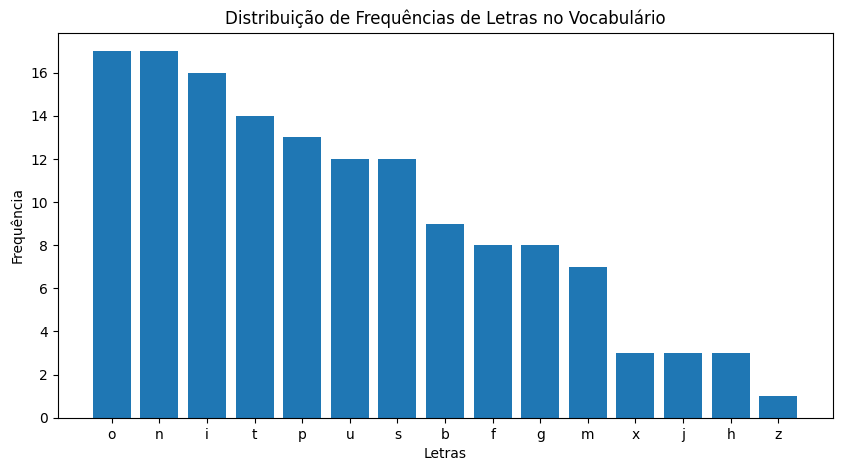

In [15]:
letras, frequencias = zip(*sorted(jogador.probs.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.bar(letras, frequencias)
plt.xlabel('Letras')
plt.ylabel('Frequência')
plt.title('Distribuição de Frequências de Letras no Vocabulário')
plt.show()


### Explicação
Este gráfico ilustra a redução no tamanho do vocabulário ao longo do jogo. Ele mostra como o espaço de busca diminui progressivamente, melhorando a eficiência do jogador ao adivinhar.


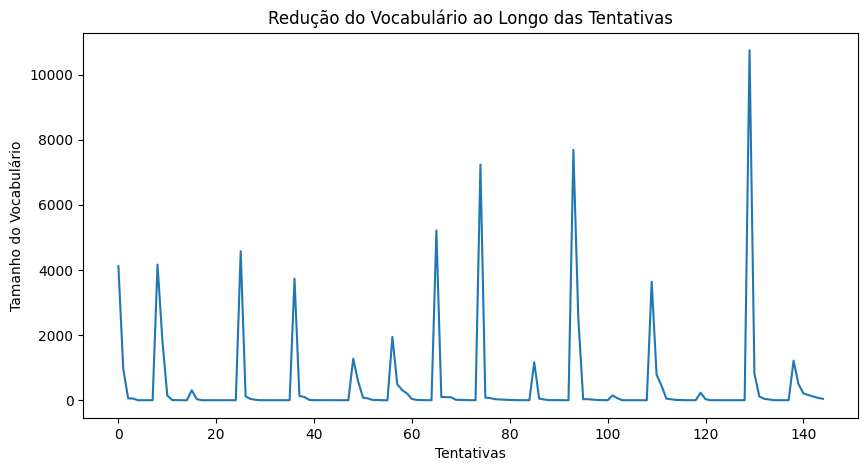

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(vocab_size[1:])
plt.xlabel('Tentativas')
plt.ylabel('Tamanho do Vocabulário')
plt.title('Redução do Vocabulário ao Longo das Tentativas')
plt.show()


### Explicação
Este bloco exibe os resultados finais da simulação, mostrando o número total de palavras acertadas e as vidas restantes.


In [17]:
print("Número de palavras acertadas:", palavras_certas)
print("Vidas restantes:", forca.vidas)

Número de palavras acertadas: 15
Vidas restantes: 0
